# Week 7: Hypothesis Testing, A/B Testing
---

Tonight we'll be conducting our own A/B test and extracting useful business insights!

In [1]:
import babypandas as bpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from notebook.services.config import ConfigManager

cm = ConfigManager()
cm.update(
   "livereveal", {
       'width': 1500,
       'height': 500,
       "scroll": True,
})

{'width': 1500, 'height': 500, 'scroll': True}

You've just been hired as the Chief Data Scientist for CALPIRG.  You're being tasked with helping the UX (user experience) team tweak your website to try to get more people to pledge to Save the Bees™.  Here are the two strategies the team has come up with:
1. Have a pledge button and call-to-action on just the main page of the site
2. Have a popup with the pledge button and call-to-action whenever you visit the site

As a data scientist, it is your job to see which method is more effective at driving pledges (we'll simply call them "clicks").  It is also your job to create a compelling argument to convince CALPIRG to act in accordance to your findings.

Ready?  Let's begin.

# Step 0: Why do we do hypothesis testing?
---

Simply comparing the average of the two groups has a lot of room for error.

Have you ever heard of a difference being "*statistically significant*"?  We don't just want to see if there's a difference—we want to know if that difference is caused by something, or if it's even a significant difference in the first place!

We're able to determine if something is significant or not by hypothesis testing.

Hypothesis testing helps with the following:
* Figuring out the differences between two measurements when we're looking at a **sample** instead of the population
* Figuring out if a difference could have happened by random chance
* Establishing **causation** if we conducted an experiment

# Step 1: Choosing our hypotheses
---
Recall, when conducting a hypothesis test we generate two hypotheses:

### The Null Hypothesis (H<sub>0</sub>):
States that nothing really changed.  Technically, it states that both of the samples came from the same population.

### The Alternative Hypothesis (H<sub>A</sub>):
States that there is a difference between the two distributions from which the samples were taken.

### Alright, let's create our two hypotheses together

Reminder: Our proposed change is to add a pop up window any time a user visits a page with a pledge button and a call for action. These things are currently only on the main page in a non popup format.

# It's important to be specific when working with statistics.

# Similar (more mathmatical) hypotheses:

# Step 2: Setting up the experiment
---

Now we need to figure out how to test this (and how to measure the results).

Since we are scientists, after all, it is important that we follow some rules when conducting experiements:
- The experiment must be controlled
- The experiment must have a randomly assigned treatment and control group
- The experiment must not be harmful
- The experiment must produce results that can evaluate a hypothesis
- The results must be reproducible (the experiment must be able to be repeated)

Well, I hope we're not harming anyone by showing them a few popups.  As for fulfilling the rest of the requirements, what do you think is a good way to create our experiment?

Our experiment is a Random Controlled Trial (RCT), as opposed to an Observational Study.  What does this mean we can conclude from the results of the experiment?

# Step 3: Execute the experiment
---

Now we implement this experiment in the code for the website.  We need to make sure to record the results!

We received 1000 visitors over the last week, and kept track of which group they were in and whether they pledged.

`0 = Did not pledge; 1 = Pledged`

In [2]:
data = bpd.read_csv("popup-test.csv")

In [3]:
data

,Group,Click
0,Control,1
1,Treatment,0
2,Control,0
3,Control,1
4,Treatment,0
...,...,...
995,Control,1
996,Treatment,0
997,Control,0
998,Treatment,0


# Is this the population?

# Step 4: Test the null hypothesis
---

Let's establish something thing before we go any further:
- What is the statistic we are trying to test for?

In [4]:
# Let's find that difference from our sample above
clicks = data.groupby("Group").sum()
clicks

,Click
Group,
Control,160
Treatment,197


In [5]:
groups = data.groupby("Group").count()
groups

,Click
Group,
Control,476
Treatment,524


In [6]:
rates = np.array(clicks.get("Click") / groups.get("Click"))

In [7]:
click_rates = bpd.DataFrame().assign(
    Group = ["Control", "Treatment"],
    Rate = rates
)
click_rates

,Group,Rate
0,Control,0.336134
1,Treatment,0.375954


In [8]:
data.groupby("Group").mean()

,Click
Group,
Control,0.336134
Treatment,0.375954


In [9]:
rates = click_rates.get("Rate")
observed_diff = rates.iloc[1] - rates.iloc[0]
observed_diff

0.0398197446917698

## Is this a big difference? What does it suggest about our null and alternative hypothesis?

## Our next step is figure out how likely it is to observe that observed_diff >= 0.4.
---
### Why look for "observed_diff >= 0.4"?  Why not "observed_diff  == 0.4"?

The probability of getting exactly that distance is really, really slim (on a truly continous scale its actually impossible). 

Because on a continous scale, when you say 0.4, it means 0.400000000000... with 0s all the way until infinity. It is more reasonable to use ranges of values.

Also, if we're trying to say that it's unlikely we'd get a distance of 4%, then wouldn't we also say it's increasingly unlikely to get a distance greater than 4%?

### A bit more detail into testing the null hypothesis

What is the null hypothesis?

> The popup has no effect.  The click rate for visitors who get the popup and for visitors who don't come **from the same population**.

Recall, when we run a hypothesis test we are **trying to reject the null hypothesis**.  How would we do that?

# How should we design our hypothesis test?

### ??? test

All we have is a sample.  We have no other knowledge of our population.

We can compare our sample to randomly generated samples according to the rules of the null hypothesis. 

In [10]:
np.random. ...([0,1,2,3,4,5,6,7,8,9])

array([0, 4, 1, 3, 6, 8, 7, 9, 5, 2])

In [11]:
# Let's conduct the permutation test
trials = 100
differences = np.array([])

for i in range(trials):
    if i % 10 == 0: print(i, end= ', ')
        
    # We choose one of the columns, either the Group or the Click, to shuffle
    shuffled_clicks = np.random.permutation(data.get('Click'))

    # Then we match it back up with our other column
    shuffled_data = data.assign(
        Shuffled_Click = shuffled_clicks
    )
    
    # Now, we see what differences we get after shuffling
    click_rates = shuffled_data.groupby("Group").mean().get("Shuffled_Click")
    
    difference = click_rates.iloc[1] - click_rates.iloc[0]
    differences = np.append(differences, difference)

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 

In [12]:
 differences[:10], len(differences)

(array([ 0.00373661, -0.01230034, -0.02833729, -0.06442042, -0.00428187,
        -0.00428187,  0.00373661,  0.0237828 , -0.01630958,  0.01576432]), 100)

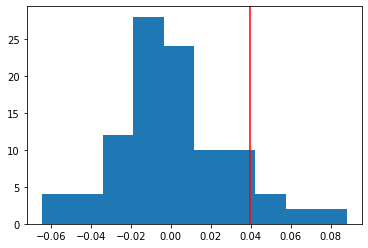

In [13]:
# Let's visualize the distribution of differences
plt.hist(differences)

# Where does our observed difference land?
plt.axvline(observed_diff, c='r');

In [14]:
# What's the p value chance of a difference gt_eq the observed difference occurring?
p = np.count_nonzero(...) / ...
p 

0.09

## It seems like the 4% difference is a not enough to declare that the popups will increase click rate!

## The above is testing if there is an increase in clicks due to the change, how would we change the line of code above to be testing for any change in clicks (either increase or decrease)?

In [15]:
np.count_nonzero(...) / ...

0.16

### Another type of test
Let's say that we know the average click rate for visitors is 0.4.  Then, we can test the null hypothesis by simulation as opposed to permutation.

Here we are just using the information above to simulate our data, we are not using any dataset.

In [19]:
trials = 500
visitors = 1000
differences = np.array([])

for i in range(trials):
    if i % 50 == 0: print(i, end= ', ')
    d = {"Control": {"visitors": 0, "clicks": 0}, "Treatment": {"visitors": 0, "clicks": 0}}
    
    for visitor in range(visitors):
        # 50% chance of being in treatment
        group = np.random.choice(["Treatment", "Control"])

        # 40% chance of clicking
        click = np.random.choice([1, 0], p=[0.4, 0.6])
        
        d[group]["visitors"] += 1
        d[group]["clicks"] += click
        
    rate_control = d["Control"]["clicks"] / d["Control"]["visitors"]
    rate_treatment = d["Treatment"]["clicks"] / d["Treatment"]["visitors"]
    difference = rate_treatment - rate_control
    
    differences = np.append(differences, difference)

0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 

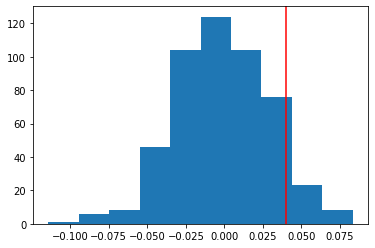

In [20]:
# Let's visualize the distribution of differences
plt.hist(differences)

# Where does our observed difference land?
plt.axvline(observed_diff, c='r');

In [21]:
# p-value
p = np.count_nonzero(np.array(differences) >= observed_diff) / len(differences)
p

0.092

# Step 5: Interpret the results
---

In order to interpret the results, and figure out whether or not the observed difference was statistically significant, we need to set a significance level, **<code>&alpha;</code>**.

The significance level is defined as the probability of making a "Type I Error" in which we reject the null hypothesis when it is actually true.  Meaning, if we set $\alpha = 0.05$ then we have 5% chance of mistakenly rejecting the null hypothesis.


From our experiment, we calculate a **<code>p-value</code>**.

The p-value is the defined as the probability of observing a difference greater than or equal to the observed difference if the null hypothesis were to be true.

Question: 

If the p-value is less than or equal to the significance level, do we **reject / accept** the null hypothesis and **reject / accept** the alternative hypothesis?

## Since this is RCT (random controlled trial) experiment, what does supporting the alternative hypothesis imply?

## Because the p-value is greater than alpha, then we...

We **fail to reject** the null hypothesis.

So, now it's time to prepare our presentation to CALPIRG:

---

## Presentation to CALPIRG

Our data and initial observation: 

Our methodology:

Our (alternative) hypothesis: 

Mathematical results: 

Conceptual result: 

Action to take: 

Summary: 

## Presentation to CALPIRG

**Our data and initial observation:** We collected 1000 users' interactions with the ads and saw a slightly greater click percentage for the popups.

**Our methodology:** We used an **A/B test experiment** in which we assigned half of the users to get popups and the other half to get no popups.

**Our (alternative) hypothesis:** We proposed our hypotheses of: popups statistically significantly increase click percentage.

**Mathematical results:** We set our significance level as $\alpha = 0.05. After running a **permutation hypothesis test** we discovered a p value of **0.092**. Our p-value **is greater than 0.05** and, therefore we can't reject the null hypothesis and accept our alternative hypothesis.

**Conceptual result:** We can't conclude that popups will increase the click percentage. We don't have enough statistical evidence to do so, with our current experimental setup.

**Action to take:** In order to get more people to pledge while visiting the website, we currently don't know for sure either way which will be better. If further results are needed, we will need to alter our experimental setup, either with more data or a different ad setup.

**Summary:** Even though popups created an observed greater click percentage, we don't have enough evidence to say that the difference is statistically significant.